## MNIST Image Classification with an RNN Model

### Build the dataset and dataloader

In [1]:
import torch
import torchvision
from torchvision import transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/Users/rowel/anaconda3/envs/agents/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:04<00:00, 2202830.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 121115.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:03<00:00, 488386.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1158368.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Visualize samples from the dataset

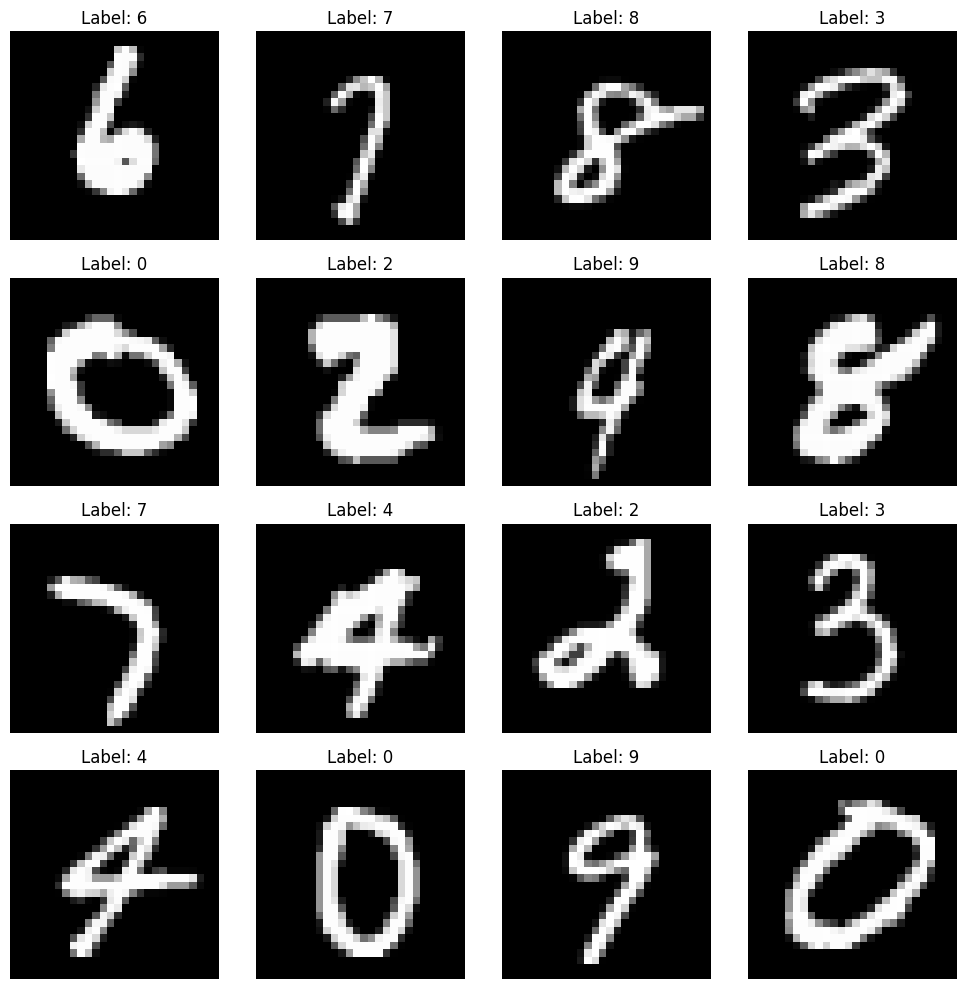

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


### Build the RNN Model

In [7]:
import torch
import torch.nn as nn

# Build an RNN model to classsify MNIST images
class RNN(nn.Module):
    def __init__(self, input_size=28, hidden_size=256, num_layers=1, num_classes=10):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # input is a "sequence" of 28 features w/ length 28
        x = x.squeeze(1)
        y, h = self.rnn(x) #, h0)
        # retrieve the last element of the sequence
        # print("y.shape:", y.shape). # b, 28, 256
        y = self.fc(y[:, -1, :]) # b, 10
        return y, h


x = torch.randn(64, 1, 28, 28)
model = RNN()
print(model)
y , h = model(x)

print("h.shape:", h.shape)
print("y.shape:", y.shape)


# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")

RNN(
  (rnn): RNN(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)
h.shape: torch.Size([1, 64, 256])
y.shape: torch.Size([64, 10])
Number of parameters: 75,786


### Define the loss function and optimizer

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [10]:
from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:19<02:59, 19.91s/it]

Epoch: 1, Loss: 0.5974


 20%|██        | 2/10 [00:38<02:35, 19.40s/it]

Epoch: 2, Loss: 0.2706


 30%|███       | 3/10 [00:58<02:15, 19.33s/it]

Epoch: 3, Loss: 0.2112


 40%|████      | 4/10 [01:20<02:03, 20.58s/it]

Epoch: 4, Loss: 0.1791


 50%|█████     | 5/10 [01:46<01:52, 22.49s/it]

Epoch: 5, Loss: 0.1534


 60%|██████    | 6/10 [02:09<01:30, 22.62s/it]

Epoch: 6, Loss: 0.1454


 70%|███████   | 7/10 [02:32<01:08, 22.78s/it]

Epoch: 7, Loss: 0.1380


 80%|████████  | 8/10 [02:55<00:45, 22.74s/it]

Epoch: 8, Loss: 0.1303


 90%|█████████ | 9/10 [03:18<00:23, 23.02s/it]

Epoch: 9, Loss: 0.1226


100%|██████████| 10/10 [03:42<00:00, 22.21s/it]

Epoch: 10, Loss: 0.1247


### Evaluate the model

In [12]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9681


### Predict on sample images

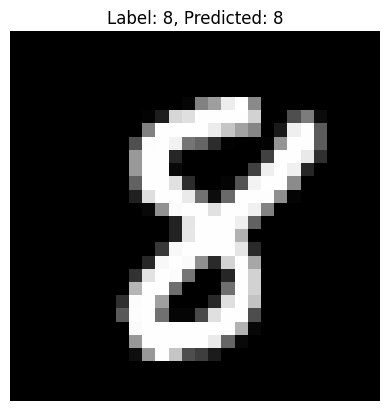

In [14]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output, _ = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()
